In [10]:
import argparse
import json
import pickle
import json
import os

import pandas as pd

from nilearn.datasets import fetch_neurovault, fetch_atlas_difumo
from nilearn.maskers import NiftiMasker
import nibabel

# Loading 3D data

In [3]:
#adapted from https://github.com/rmenuet/fmri_decoding/blob/master/Experiment/a1_collect.py

# ================================
# === FETCHING FROM NEUROVAULT ===
# ================================
def fetch_nv(repo, nv_file,
             download=False,
             max_images=None):
    """
    Loads neurovault into memory, either downloading it from the web-API or
    loading it from the disk.
    :param repo: str
        Path where the data is downloaded.
    :param nv_file: str
        Pickle file where the full data is saved
        (for faster loading than the fetch_neurovault).
    :param download: bool, default=False
        If True: the data is downloaded from the web-API.
    :param max_images: int, default=None
        Number of images to load from neurovalt.
    :return: Bunch
        A dict-like object containing the data from fMRIs fetched from
        Neurovault.
    """

    # Download and save to disk or load from disk

    if download:

        print("...Download from Neurovault API...")
        os.makedirs(repo, exist_ok=True)
        os.makedirs(nv_filepath, exist_ok=True)
        nv_file=os.path.join(nv_filepath, "nv_meta.p")
        
        neurovault = fetch_neurovault(max_images=max_images,
                                      collection_terms={},
                                      image_terms={},
                                      data_dir=repo,
                                      mode="download_new",
                                      verbose=2,
                                      collection_id= 4337)
        
        with open(nv_file, 'wb') as f:
            pickle.dump(neurovault, f)
    else:
       
        print("...Load pre-fetched data from Neurovault...")
        with open(nv_file, 'rb') as f:
            neurovault = pickle.load(f)

    n_fmri_dl = len(neurovault.images)

    print("  > Number of (down)loaded fmri =", n_fmri_dl)

    return neurovault

In [4]:
nv_path= "../../Data/neurovault/"
nv_filepath = "../../cache/"
download=True
max_images=10
neurovault = fetch_nv(nv_path, nv_filepath , download, max_images= max_images)


...Download from Neurovault API...

Dataset created in ../../Data/neurovault/neurovault

No image found on local disk.
Already fetched 1 image
Already fetched 2 images
Already fetched 3 images
Already fetched 4 images
Already fetched 5 images
Already fetched 6 images
Already fetched 7 images
Already fetched 8 images
Already fetched 9 images
Already fetched 10 images
  > Number of (down)loaded fmri = 10


In [5]:
### Show image example

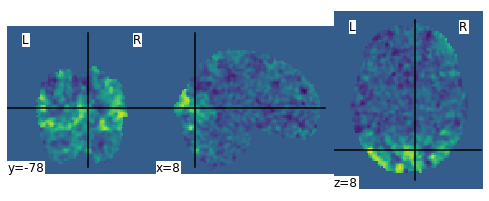

In [6]:
from nilearn import plotting
plotting.plot_img(neurovault["images"][0])

# Projection 3D data into DiFuMo space

In [18]:
# DiFuMo dictionary matrix
difumo = fetch_atlas_difumo(dimension=1024)

difumo_maps = nibabel.load(difumo["maps"])

difumo_maps.shape

/storage/store2/work/crommel/miniconda/envs/braindecode/lib/python3.8/site-packages/nilearn/datasets/atlas.py:130: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


(104, 123, 104, 1024)

In [19]:
# One activation map

data = nibabel.load(neurovault["images"][0]).get_data()
data.shape

<ipython-input-19-c944b9df04c6>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = nibabel.load(neurovault["images"][0]).get_data()


(91, 109, 91)

In [20]:
# Object used to project onto DiFuMo space

masker = NiftiMasker(mask_img=difumo_maps, standardize=True)

In [21]:
# Projection

projected_data = masker.fit_transform(data)

DimensionError: Input data has incompatible dimensionality: Expected dimension is 3D and you provided a 4D image. See https://nilearn.github.io/stable/manipulating_images/input_output.html.